<a href="https://colab.research.google.com/github/dwaipayan05/CovCNN-WebApp/blob/main/COVID_Chest_X_Ray_(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Necessary Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
/device:GPU:0
Num GPUs Available:  1


In [ ]:
%cd /content/gdrive/"My Drive"/"COVID Chest X-Ray Analysis"

/content/gdrive/My Drive/COVID Chest X-Ray Analysis


**Fetch Dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/COVID Chest X-Ray Analysis"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

/content/gdrive/My Drive/COVID Chest X-Ray Analysis
sarscov2-ctscan-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sarscov2-ctscan-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find sarscov2-ctscan-dataset.zip.ZIP, period.

No zipfiles found.


**Split Into Train Data & Test Data**

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/COVID Chest X-Ray Analysis/Dataset'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:15, 165.16it/s]


(2481, 150, 150, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

**Define VGG16 Model Architecture**

In [ ]:
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model._name = "VGG16_Architecture"
model.summary()

Model: "VGG16_Architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)

**Train the Model**

In [ ]:
training_datagen = ImageDataGenerator(rotation_range=40, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)
training_datagen.fit(X_train)


filepath="VGG16_Model.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

history = model.fit_generator(train_generator, steps_per_epoch=32, epochs=200,
                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
32/32 [==============================] - 25s 593ms/step - loss: 0.9404 - accuracy: 0.5515 - val_loss: 0.6783 - val_accuracy: 0.5863

Epoch 00001: val_loss improved from inf to 0.67826, saving model to VGG16_Model.hdf5
Epoch 2/200
32/32 [==============================] - 12s 380ms/step - loss: 0.8159 - accuracy: 0.6373 - val_loss: 0.6586 - val_accuracy: 0.6586

Epoch 00002: val_loss improved from 0.67826 to 0.65860, saving model to VGG16_Model.hdf5
Epoch 3/200
32/32 [==============================] - 12s 377ms/step - loss: 0.7346 - accuracy: 0.6698 - val_loss: 0.6439 - val_accuracy: 0.6707

Epoch 00003: val_loss improved from 0.65860 to 0.64388, saving model to VGG16_Model.hdf5
Epoch 4/200
32/32 [==============================] - 12s 381ms/step - loss: 0.7050 - accuracy: 0.6715 - val_loss: 0.6311 - val_accuracy: 0.6988

Epoch 00004: val_loss improved from 0.64388 to 0.63115, saving model to VGG16_Model.hdf5
Epoch 5/200
32/32 [==============================] - 12s 377ms/step 

**Plot the Results**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

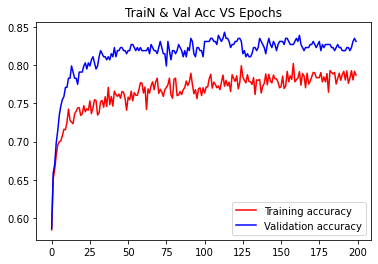

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

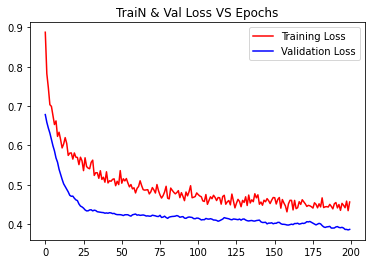

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("VGG16_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

8/8 [==============================] - 38s 437ms/step - loss: 0.3655 - accuracy: 0.8612
Test Loss: 0.3781876862049103
Test accuracy: 85.14056205749512


Text(0.5, 1.0, 'Confusion Matrix')

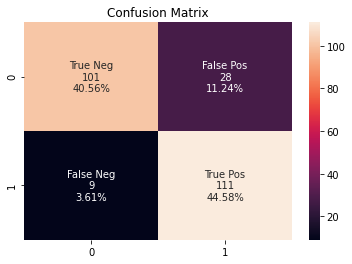

In [ ]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")